In [5]:
from tdc.single_pred import ADME
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import utils
import train

In [12]:
sns.set_palette("Set2")

In [6]:
task_names = [
    "caco2_wang",
    "Half_Life_Obach",
    "bbb_martins",
    "cyp2c19_veith",
]
task_types = [
    "regression",
    "regression",
    "classification",
    "classification",
]
tdc_datasets = [ADME(name) for name in task_names]

Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!
Found local copy...
Loading...
Done!


In [7]:
scores = {}
for task_type, tdc_dataset in zip(task_types, tdc_datasets):
    print("Running ", tdc_dataset.name)
    scores[tdc_dataset.name] = {}

    dc_dataset = utils.make_dc_split(tdc_dataset, "ecfp")
    rf_model = train.train_rf_model(dc_dataset, task_type)
    scores[tdc_dataset.name]["rf"] = utils.evaluate(rf_model, dc_dataset, task_type)

    dc_dataset = utils.make_dc_split(tdc_dataset, "molgraphconv")
    gcn_model = train.train_graph_model(dc_dataset, task_type, "gcn")
    scores[tdc_dataset.name]["gcn"] = utils.evaluate(gcn_model, dc_dataset, task_type)
    gat_model = train.train_graph_model(dc_dataset, task_type, "gat")
    scores[tdc_dataset.name]["gat"] = utils.evaluate(gat_model, dc_dataset, task_type)

Running  caco2_wang


100%|██████████| 910/910 [00:01<00:00, 713.59it/s]


Running  half_life_obach


100%|██████████| 667/667 [00:00<00:00, 1065.59it/s]


Running  bbb_martins


100%|██████████| 2030/2030 [00:02<00:00, 806.92it/s]


Running  cyp2c19_veith


100%|██████████| 12665/12665 [00:09<00:00, 1330.46it/s]


In [9]:
regression_df = pd.concat(
    [
        pd.DataFrame(scores["caco2_wang"]),
        pd.DataFrame(scores["half_life_obach"]),
    ]
)
regression_df["task"] = task_names[:2]
regression_df = regression_df.set_index("task")

In [10]:
regression_df.to_csv("outputs/regression_scores.csv")

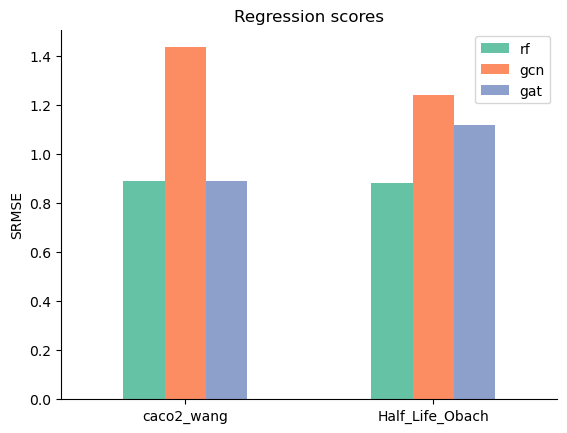

In [13]:
ax = regression_df.plot(kind="bar")
sns.despine()
ax.set_title("Regression scores")
ax.set_xlabel("")
ax.set_ylabel("SRMSE")
plt.xticks(rotation=0, ha="center")
plt.savefig("outputs/regression_score.png", dpi=600)

In [14]:
classification_df = pd.concat(
    [pd.DataFrame(scores[name]) for name in task_names[2:]]
).drop(["prc"])
classification_df["task"] = task_names[2:]
classification_df = classification_df.set_index("task")
classification_df.to_csv("outputs/classification_scores.csv")

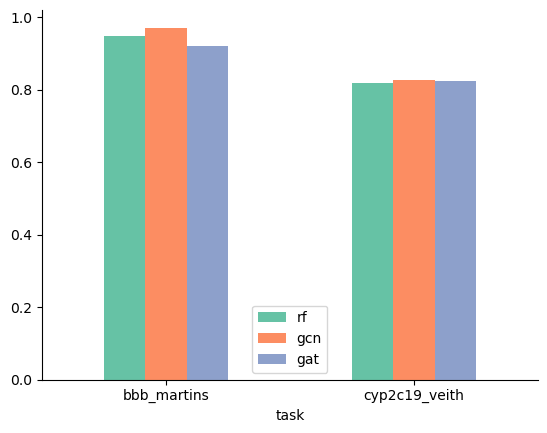

In [15]:
classification_df.plot(kind="bar")
sns.despine()
ax.set_xlabel("")
ax.set_ylabel("AUPRC")
ax.set_ylabel("")
ax.set_title("Classification scores (AUPRC)")
plt.xticks(rotation=0, ha="center")
plt.savefig("outputs/classification_score.png", dpi=600)

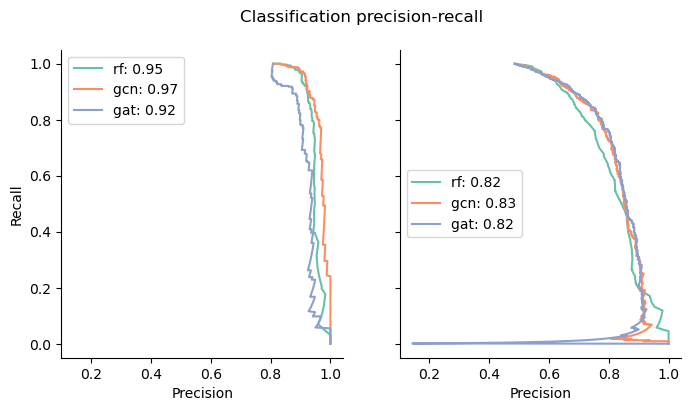

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, sharex=True)
for i, task in enumerate(task_names[2:]):
    for model, score in scores[task].items():
        precision, recall, thresholds = score["prc"]
        axs[i].plot(precision, recall, label=f'{model}: {score["auc"]:.2f}')
    axs[i].legend()
    sns.despine()

axs[0].set_xlabel("Precision")
axs[1].set_xlabel("Precision")
axs[0].set_ylabel("Recall")
fig.suptitle("Classification precision-recall")
plt.savefig("outputs/classification_prc.png", dpi=600)

In [17]:
import pickle

with open("outputs/scores.pickle", "wb") as handle:
    pickle.dump(scores, handle, protocol=pickle.HIGHEST_PROTOCOL)